# Implementation of "A Neural Algorithm of Artistic Style"

### 1. Imports

In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# to retain original image color after style transfer
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

/home/dikatok/miniconda3/envs/deeplearning/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### 2. Configuration

In [2]:
STYLE_IMG = "./images/style.png"
CONTENT_IMG = "./images/content.jpg"
RESULT_IMG = "./images/result.jpg"
VGG_WEIGHT = "../vgg16_weights.npz"
LOG_DIR = "./logs"

NUM_ITER = 500
LEARNING_RATE = 10
LOG_ITER = 50
SAMPLE_ITER = 100
STYLE_SIZE = 512
CONTENT_SIZE = 512

CONTENT_LOSS_WEIGHT = 1
STYLE_LOSS_WEIGHT = 10000

### 3. Load style and content image

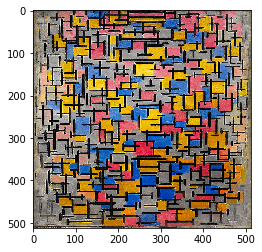

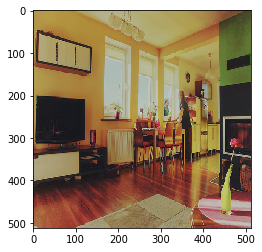

In [3]:
# load and resize style image and convert it to ndarray
style_image = tf.keras.preprocessing.image.img_to_array(img=tf.keras.preprocessing.image.load_img(STYLE_IMG, target_size=(STYLE_SIZE,STYLE_SIZE)))
# load and resize content image and convert it to ndarray
content_image = tf.keras.preprocessing.image.img_to_array(img=tf.keras.preprocessing.image.load_img(CONTENT_IMG, target_size=(CONTENT_SIZE,CONTENT_SIZE)))

plt.imshow(style_image / 255.)
plt.show()
plt.imshow(content_image / 255.)
plt.show()

### 4. VGG and loss definition

In [4]:
def vgg16(x, weights):
    # substract imagenet mean
    mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='imagenet_mean')
    x = x - mean
    
    with tf.variable_scope("vgg16", reuse=tf.AUTO_REUSE):
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv1_1_W"]), trainable=False, name='conv1_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv1_1_b"]), trainable=False, name='conv1_1_b')
            conv1_1 = tf.nn.conv2d(x, kernel, [1, 1, 1, 1], padding='SAME')
            conv1_1 = tf.nn.bias_add(conv1_1, biases)
            conv1_1 = tf.nn.relu(conv1_1, name=scope)

        with tf.name_scope('conv1_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv1_2_W"]), trainable=False, name='conv1_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv1_2_b"]), trainable=False, name='conv1_2_b')
            conv1_2 = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv1_2 = tf.nn.bias_add(conv1_2, biases)
            conv1_2 = tf.nn.relu(conv1_2, name=scope)

        pool1 = tf.nn.avg_pool(conv1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', 
                               name='pool1')

        with tf.name_scope('conv2_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv2_1_W"]), trainable=False, name='conv2_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv2_1_b"]), trainable=False, name='conv2_1_b')
            conv2_1 = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
            conv2_1 = tf.nn.bias_add(conv2_1, biases)
            conv2_1 = tf.nn.relu(conv2_1, name=scope)

        with tf.name_scope('conv2_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv2_2_W"]), trainable=False, name='conv2_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv2_2_b"]), trainable=False, name='conv2_2_b')
            conv2_2 = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv2_2 = tf.nn.bias_add(conv2_2, biases)
            conv2_2 = tf.nn.relu(conv2_2, name=scope)

        pool2 = tf.nn.avg_pool(conv2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                               name='pool2')

        with tf.name_scope('conv3_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_1_W"]), trainable=False, name='conv3_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_1_b"]), trainable=False, name='conv3_1_b')
            conv3_1 = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_1 = tf.nn.bias_add(conv3_1, biases)
            conv3_1 = tf.nn.relu(conv3_1, name=scope)

        with tf.name_scope('conv3_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_2_W"]), trainable=False, name='conv3_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_2_b"]), trainable=False, name='conv3_2_b')
            conv3_2 = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_2 = tf.nn.bias_add(conv3_2, biases)
            conv3_2 = tf.nn.relu(conv3_2, name=scope)

        with tf.name_scope('conv3_3') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_3_W"]), trainable=False, name='conv3_3_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_3_b"]), trainable=False, name='conv3_3_b')
            conv3_3 = tf.nn.conv2d(conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_3 = tf.nn.bias_add(conv3_3, biases)
            conv3_3 = tf.nn.relu(conv3_3, name=scope)

        pool3 = tf.nn.avg_pool(conv3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                               name='pool3')

        with tf.name_scope('conv4_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_1_W"]), trainable=False, name='conv4_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_1_b"]), trainable=False, name='conv4_1_b')
            conv4_1 = tf.nn.conv2d(pool3, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_1 = tf.nn.bias_add(conv4_1, biases)
            conv4_1 = tf.nn.relu(conv4_1, name=scope)

        with tf.name_scope('conv4_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_2_W"]), trainable=False, name='conv4_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_2_b"]), trainable=False, name='conv4_2_b')
            conv4_2 = tf.nn.conv2d(conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_2 = tf.nn.bias_add(conv4_2, biases)
            conv4_2 = tf.nn.relu(conv4_2, name=scope)

        with tf.name_scope('conv4_3') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_3_W"]), trainable=False, name='conv4_3_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_3_b"]), trainable=False, name='conv4_3_b')
            conv4_3 = tf.nn.conv2d(conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_3 = tf.nn.bias_add(conv4_3, biases)
            conv4_3 = tf.nn.relu(conv4_3, name=scope)
            
    return conv1_2, conv2_2, conv3_3, conv4_3

def gram_matrix(x):
    batch_size, w, h, ch = x.shape.as_list()
    x = tf.reshape(x, [batch_size, w * h, ch])
    return tf.matmul(x, x, transpose_a=True) / (ch * w * h)

def loss_fun(target_style_features, target_content_features, transferred_features, 
             style_loss_weight=STYLE_LOSS_WEIGHT, content_loss_weight=CONTENT_LOSS_WEIGHT):
    # relu3_3 as content features  instead of relu4_2 in the original work
    content_loss = 2 * tf.nn.l2_loss(target_content_features[2] - transferred_features[2])
    
    # relu1_2, relu2_2, relu3_3, relu4_3 as style features 
    # instead of relu1_1, relu2_1, ..., relu5_1 in the original work
    style_loss = 0
    for i in range(len(transferred_features)):
        gram_target = gram_matrix(target_style_features[i])
        gram_transferred = gram_matrix(transferred_features[i])
        style_loss = style_loss + 2 * tf.nn.l2_loss(gram_target - gram_transferred)
        
    return content_loss_weight * content_loss + style_loss_weight * style_loss

### 5. Optimization

Next, we will begin the optimization, first we will load the vgg model and it's weights then use Adam as optimizer. Tensorboard is used to visualize the graph, loss and result sample.

In [5]:
# load vgg weights
vgg_weights = np.load(VGG_WEIGHT)

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Graph().as_default() as g, tf.Session(config=config) as sess:
    s = sess.run(tf.expand_dims(style_image, axis=0))
    c = sess.run(tf.expand_dims(content_image, axis=0))

    style = tf.placeholder(name="style", dtype=tf.float32, shape=[1,STYLE_SIZE,STYLE_SIZE,3])
    content = tf.placeholder(name="content", dtype=tf.float32, shape=[1,CONTENT_SIZE,CONTENT_SIZE,3])
    
    # the result image to optimize
    transferred = tf.clip_by_value(tf.Variable(initial_value=c, dtype=tf.float32), 0, 255)
    
    # extract style image's features
    target_style_features = vgg16(style, vgg_weights)

    # extract content image's features
    target_content_features = vgg16(content, vgg_weights)

    # extract the result image's features
    transferred_features = vgg16(transferred, vgg_weights)

    # calculate the loss between transferred image and the original image + style
    loss = loss_fun(target_style_features, target_content_features, transferred_features)
        
    train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)
    
    loss_summary = tf.summary.scalar("loss", loss)
    
    summary = tf.summary.FileWriter(graph=g, logdir=LOG_DIR)

    sess.run(tf.global_variables_initializer())
    
    start = time.time()
    for i in range(NUM_ITER):
        it = i + 1

        _, cur_loss, cur_loss_summary = sess.run([train_op, loss, loss_summary], 
                                                                          feed_dict={style: s, content: c})

        if it % LOG_ITER == 0:
            print("Iteration:", it, "loss:", cur_loss)
            
        summary.add_summary(cur_loss_summary, it)
        summary.flush()
        
    end = time.time()
    
    result = sess.run(tf.squeeze(transferred))

Iteration: 50 loss: 2.77392e+12
Iteration: 100 loss: 1.28353e+12
Iteration: 150 loss: 1.01672e+12
Iteration: 200 loss: 9.15619e+11
Iteration: 250 loss: 8.62988e+11
Iteration: 300 loss: 8.29939e+11
Iteration: 350 loss: 8.06883e+11
Iteration: 400 loss: 7.89608e+11
Iteration: 450 loss: 7.762e+11
Iteration: 500 loss: 7.65327e+11


### 6. Show the result

In [6]:
print("Finished {num_iter} iteration in {time} seconds".format(num_iter=NUM_ITER, time=end-start))

Finished 500 iteration in 90.51415681838989 seconds


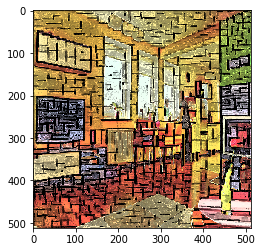

In [7]:
# retain original image color
def use_original_color(original, result):
    result_hsv = rgb_to_hsv(result)
    orig_hsv = rgb_to_hsv(original)
    oh, os, ov = np.split(orig_hsv, axis=-1, indices_or_sections=3)
    rh, rs, rv = np.split(result_hsv, axis=-1, indices_or_sections=3)
    return hsv_to_rgb(np.concatenate([oh, os, rv], axis=-1))

final_result = use_original_color(content_image.reshape((CONTENT_SIZE, CONTENT_SIZE, 3)), result)

plt.imshow(final_result / 255.)    
plt.show()

### 7. Save the result

In [8]:
result_image = tf.keras.preprocessing.image.array_to_img(final_result)
result_image.save(RESULT_IMG)

### 8. Commentary

The method Gatys et al. proposed in his work relies on the intuition that deep network trained on large amount of data such as vgg trained on imagenet dataset is able to produce important image feature in the intermediate layers. By using vgg as both transformation and loss network, we can guide/optimize a content image to have similar features as the guiding style image (denoted by the gram matrices of intermediate layers' outputs).

The problem of this optimization method is that to guide/optimize an image, we need to perform a number of iterations that can take more than 1 minute, just for a single image. This means real-time style transfer performance is hard to achieve by using optimization method, at least not with current computation resources. Until now, many researchers attempted to search for real-time style transfer methods using deep networks. One of the first advancement in real-time style transfer is Johnson et al.'s work in his paper [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155) which will be covered in part 2.

### 9. References

1. A Neural Algorithm of Artistic Style [https://arxiv.org/abs/1508.06576](https://arxiv.org/abs/1508.06576)
2. Tensorflow vgg model and weights [http://www.cs.toronto.edu/~frossard/post/vgg16/](http://www.cs.toronto.edu/~frossard/post/vgg16/)
3. Retaining original image color technique [https://github.com/yusuketomoto/chainer-fast-neuralstyle](https://github.com/yusuketomoto/chainer-fast-neuralstyle)